In [36]:
import torch
import pandas as pd
import esm
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score

import numpy as np

# Data prep


Open Non Core Pu file


In [3]:
with open("SET_PUs_NON_CORES (1).txt") as f:
    No_Pu = f.readlines()

for i in range(len(No_Pu)):
    No_Pu[i] = No_Pu[i].strip()

Open Fasta data


In [4]:
from Bio import SeqIO

fasta_file = "DB_PU_NONPU_SEQ.fasta"
fasta_sequence = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        fasta_sequence.append(record)

Open Pu File


In [5]:
Pu = pd.read_table(
    "LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies (1)", sep="\t", header=None
)

In [6]:
data = []
for line in Pu[0]:
    liste = []

    line = line.split(" ")
    for element in line:
        if element != "":
            liste.append(element)
    data.append(liste)

In [7]:
SUPERFAMILLY = []
CLASS_ARCHITECTURE = []
TOPOLOGY = []
GROUP_LENGHT = []
PROTO_FOLD_group_ID = []
FREQUENCY = []
PROTO_FOLD_PROTOTYPE = []
PU_FAMILY_MEMBERS_CATEGORY = []
for element in data[7:]:
    SUPERFAMILLY.append(element[0])
    CLASS_ARCHITECTURE.append(element[1])
    TOPOLOGY.append(element[2])
    GROUP_LENGHT.append(element[3].split(".")[0])
    PROTO_FOLD_group_ID.append(element[3].split(".")[1])
    FREQUENCY.append(element[4])
    PROTO_FOLD_PROTOTYPE.append(element[5])
    PU_FAMILY_MEMBERS_CATEGORY.append(element[6:])

In [8]:
d = {
    "SUPERFAMILLY": SUPERFAMILLY,
    "CLASS_ARCHITECTURE": CLASS_ARCHITECTURE,
    "TOPOLOGY": TOPOLOGY,
    "GROUP_LENGHT": GROUP_LENGHT,
    "PROTO_FOLD_group_ID": PROTO_FOLD_group_ID,
    "FREQUENCY": FREQUENCY,
    "PROTO_FOLD_PROTOTYPE": PROTO_FOLD_PROTOTYPE,
    "PU_FAMILY_MEMBERS_CATEGORY": PU_FAMILY_MEMBERS_CATEGORY,
}

In [9]:
Pu_families = pd.DataFrame(data=d)

Set data labels


In [10]:
Sequence = []
Is_pu = []
file = []
for record in fasta_sequence:
    Sequence.append(str(record.seq))
    file_name = f'{record.id}_{record.description.split("|")[1].split(" ")[1].split(":")[1]}_{record.description.split("|")[2].split(" ")[1].split(":")[1]}_{record.description.split("|")[3].split(" ")[1].split(":")[1]}'
    file.append(file_name)
    if file_name in No_Pu:
        Is_pu.append(0)
    elif file_name in Pu_families["PROTO_FOLD_PROTOTYPE"].values:
        Is_pu.append(1)
    else:
        Is_pu.append(2)

In [11]:
d = {"Sequence": Sequence, "Is_pu": Is_pu, "file": file}

In [12]:
seq_data = pd.DataFrame(data=d)

In [15]:
seq_data.loc[seq_data["Is_pu"] == 0]

,Sequence,Is_pu,file
134,DLFSALPTNADLYRECKFL,0,16VPA_10_41_59
173,HGDVAFPTLPATRDGL,0,16VPA_12_85_100
181,FDCLCCDLESWRQLAGLFQP,0,16VPA_13_207_226
274,AALEPTDSGAPSAIVMFPVGEKPNPKGAAMKPVVFNHLIHEKKIA,0,19HCA_10_1_45
277,EILCATCHHRSPLSLTPP,0,19HCA_10_222_239
...,...,...,...
400404,EGKFTEEVMVNFVTKEGNLPDPTNYFDFDSIYWSVNRSKSDVSYGD...,0,2JJQA_10_166_219
403207,LDPQQPIFTVPGCISATPISDILDAQLPTWGQSLTSGATLLHNKQP...,0,2NPIA_12_143_196
405713,ESTYGGFSNVIFEKSVPTPQLLRDVPDDEEYVPSVLYGCTCDGVDV...,0,2NVAA_10_281_335
409607,KVYQFDFGSGSMEPGYIGVRASDRYDRSKGYGFQTPENMRDVAASG...,0,2O14A_7_1_55


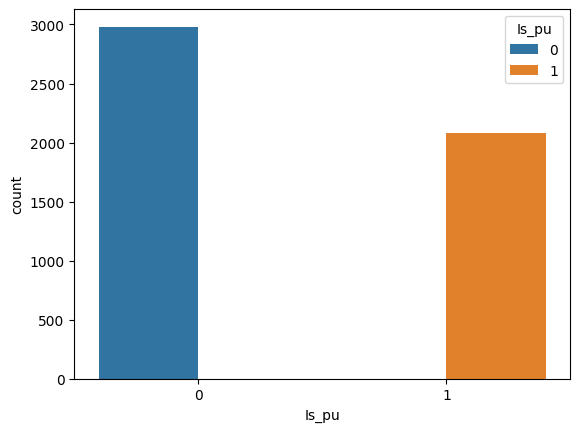

In [15]:
# Count on pu and non pu


sns.countplot(x="Is_pu", data=seq_data.loc[(seq_data["Is_pu"] != 2)], hue="Is_pu")
plt.show()

Data for embedding


In [21]:
pre_emb_pu = seq_data.loc[(seq_data["Is_pu"] == 1)][["Sequence", "file"]]
pre_emb_nonpu = seq_data.loc[(seq_data["Is_pu"] == 0)][["Sequence", "file"]]

Transformers


In [16]:
EMB_PATH_PU = "./embeddings/pu"
EMB_PATH_NONPU = "./embeddings/nonpu"

In [17]:
def embedding_preparation(pre_emb, EMB_PATH):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    for line in pre_emb.values:
        # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

        data = [(line[1], line[0])]

        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        # Extract per-residue representations (on CPU)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)

            torch.save(results, f"{EMB_PATH}/{line[1]}.pt")

In [22]:
embedding_preparation(pre_emb_pu, EMB_PATH_PU)
embedding_preparation(pre_emb_nonpu, EMB_PATH_NONPU)

In [18]:
def padding(tensor, max_size):
    if tensor.numpy().shape[0] < max_size:
        padding = max_size - tensor.numpy().shape[0]
        tensor = tf.pad(tensor, ((0, padding), (0, 0)))
    return tensor

In [19]:
# List of all embeddings
def get_embedding_list(PATH, label, max_size):
    list_of_embeddings = []
    for filename in os.listdir(PATH):
        embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][
            33
        ][0]

        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor)
    return list_of_embeddings, [label] * len(list_of_embeddings)

In [20]:
pd_non_pu, label_non_pu = get_embedding_list(EMB_PATH_NONPU, 0, 62)
pd_pu, label_pu = get_embedding_list(EMB_PATH_PU, 1, 62)

In [21]:
embeddings = pd_non_pu + pd_pu
labels = label_non_pu + label_pu

In [22]:
# Split data into train and validation
from sklearn.model_selection import train_test_split

train_set, val_set, train_labels, val_labels = train_test_split(
    embeddings, labels, test_size=0.2
)

In [23]:
def conv_data(data, labels):
    return tf.data.Dataset.from_tensor_slices((data, labels))

In [24]:
def prep_data(train, lab, batch_size):
    tf_dataset = conv_data(train, lab)
    tf_dataset = tf_dataset.batch(batch_size)
    tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)
    return tf_dataset

In [29]:
tf_dataset = prep_data(train_set, train_labels, 124)
tf_val_dataset = prep_data(val_set, val_labels, 124)

Tensorflow model:

Protein classification


In [26]:
# Compute class weights


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [27]:
model_tf = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(62, 1280)),
        tf.keras.layers.GRU(300, return_sequences=True, dropout=0.1),
        tf.keras.layers.GRU(124, dropout=0.1),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf.summary()
model_tf.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 62, 300)           1423800   
                                                                 
 gru_1 (GRU)                 (None, 124)               158472    
                                                                 
 dense (Dense)               (None, 2)                 250       
                                                                 
Total params: 1582522 (6.04 MB)
Trainable params: 1582522 (6.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model_tf.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_val_dataset,
    callbacks=callback,
    class_weight=class_weights,
)

Epoch 1/500
33/33 [==============================] - 20s 505ms/step - loss: 0.6908 - accuracy: 0.5567 - val_loss: 0.6861 - val_accuracy: 0.4837
Epoch 2/500
33/33 [==============================] - 19s 570ms/step - loss: 0.6813 - accuracy: 0.4895 - val_loss: 0.6762 - val_accuracy: 0.5163
Epoch 3/500
33/33 [==============================] - 21s 631ms/step - loss: 0.6677 - accuracy: 0.5325 - val_loss: 0.6548 - val_accuracy: 0.5716
Epoch 4/500
33/33 [==============================] - 21s 649ms/step - loss: 0.6169 - accuracy: 0.6520 - val_loss: 0.5571 - val_accuracy: 0.7167
Epoch 5/500
33/33 [==============================] - 21s 647ms/step - loss: 0.5501 - accuracy: 0.7145 - val_loss: 0.5305 - val_accuracy: 0.7315
Epoch 6/500
33/33 [==============================] - 21s 641ms/step - loss: 0.5138 - accuracy: 0.7431 - val_loss: 0.5170 - val_accuracy: 0.7581
Epoch 7/500
33/33 [==============================] - 21s 643ms/step - loss: 0.4922 - accuracy: 0.7528 - val_loss: 0.5183 - val_accuracy:

In [31]:
def plot_history(history, metric):
    plt.plot(history.history[f"{metric}"])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.legend(["train", "test"], loc="upper left")
    plt.ylabel(f"{metric}")
    plt.xlabel("epoch")
    plt.show()

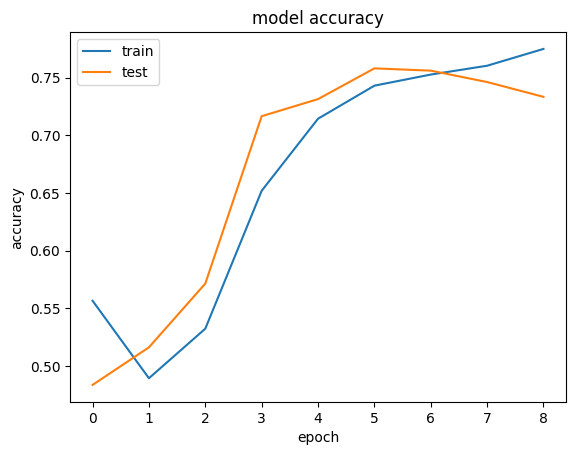

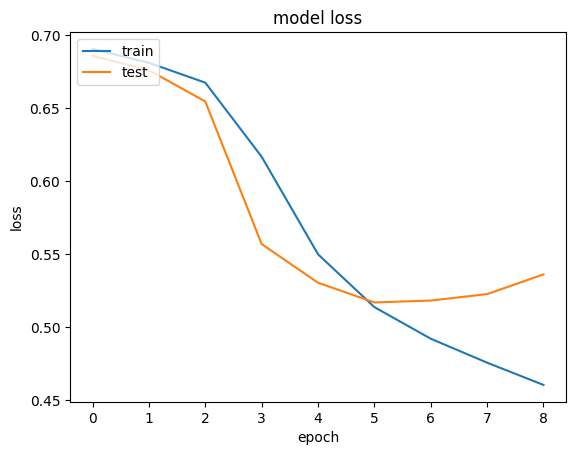

In [32]:
plot_history(model_tf.history, "accuracy")
plot_history(model_tf.history, "loss")

16/16 [==============================] - 2s 87ms/step


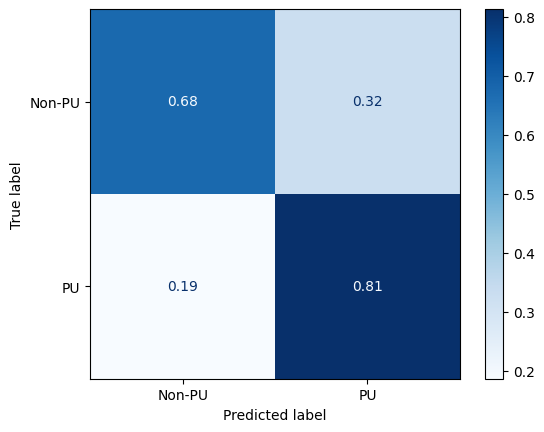

In [33]:
ConfusionMatrixDisplay.from_predictions(
    val_labels,
    model_tf.predict(prep_data(val_set, val_labels, 64)).argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

In [34]:
# Compute balanced accuracy

print(
    "Balanced accuracy: ",
    balanced_accuracy_score(
        val_labels, model_tf.predict(prep_data(val_set, val_labels, 64)).argmax(axis=1)
    ),
)

16/16 [==============================] - 2s 104ms/step
Balanced accuracy:  0.744148893681604


In [39]:
EMB_UNKOWN = "./embeddings/unknown"
unknown = seq_data.loc[(seq_data["Is_pu"] == 2)][["Sequence", "file"]]

In [ ]:
embedding_preparation(unknown, EMB_UNKOWN)

In [43]:
tensor_unknown = tf.convert_to_tensor(
    torch.load(EMB_UNKOWN + "/1A0CA_1_1_385.pt")["representations"][33][0]
)

In [56]:
set_unknown = tf.data.Dataset.from_tensor_slices(
    (tensor_unknown, [2] * len(tensor_unknown))
)
set_unknown = set_unknown.batch(128)
set_unknown = set_unknown.prefetch(tf.data.AUTOTUNE)

In [57]:
# work on size to make it predict for only one element
model_tf.predict(set_unknown)


TypeError: in user code:

    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\gru.py", line 643, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'gru' (type GRU).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'gru' (type GRU):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None
